In [1]:
#import relevant packages
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,RocCurveDisplay
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
import tensorflow

import itertools
from collections import Counter
import re
from sklearn.naive_bayes import MultinomialNB

from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D, Flatten
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
import tensorflow
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from PIL import Image
import os
import tqdm

In [2]:
import librosa
import librosa.display
from librosa import display

In [3]:
#load example audio file
ex_audio = 'audio/Music_dazSQipxqMc.wav'
sr = 22050 #define default sampling rate
sample, sample_rate = librosa.load(ex_audio, sr=sr) 

In [4]:
np.shape(sample)

(220500,)

In [5]:
spec_1 = librosa.feature.melspectrogram(y = sample, sr = sr)
spec_1.shape

(128, 431)

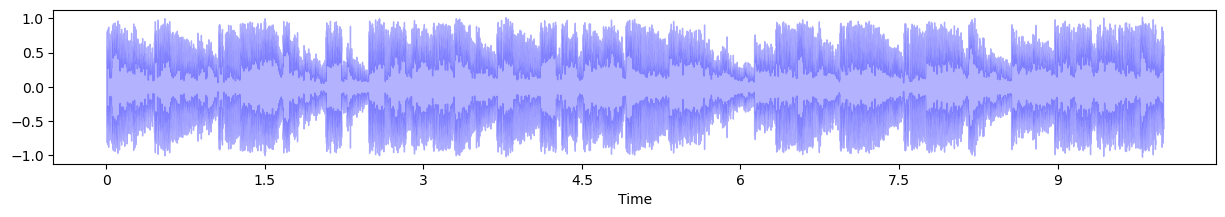

In [6]:
plt.figure(figsize=(15,2))
librosa.display.waveshow(y  = sample, sr=22050, alpha=.3, color='blue')


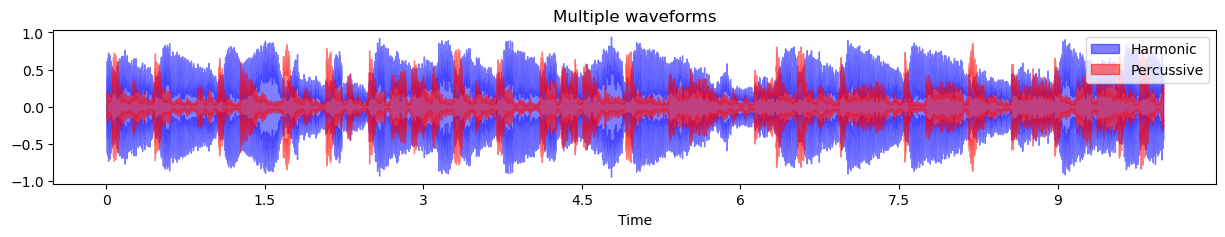

In [7]:
fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(15, 2))
y_harm, y_perc = librosa.effects.hpss(sample)
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax, label='Harmonic', color='blue')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax, label='Percussive')
ax.set(title='Multiple waveforms')
ax.legend()

In [8]:
#1. display ordinary (linear) spectrogram
D = librosa.stft(sample)  # short term fourier scale of sample
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max) #converting amplitude to decibels


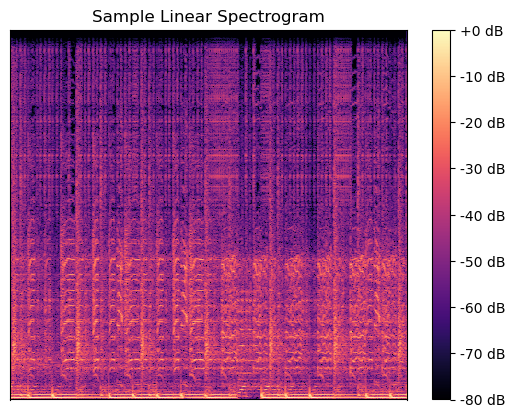

In [9]:
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, ax=ax)
ax.set(title='Sample Linear Spectrogram')
fig.colorbar(img, ax=ax, format="%+2.f dB") #amplitude units is decibels

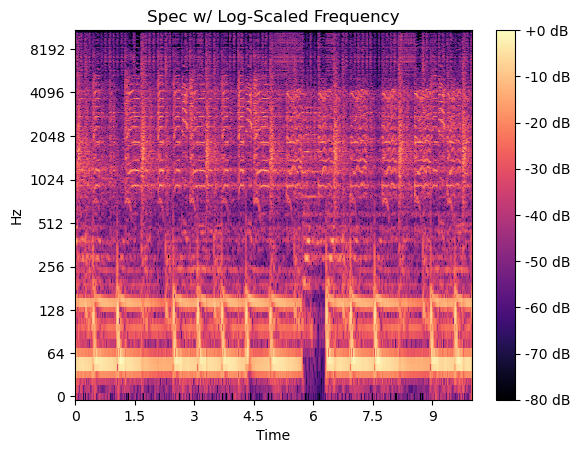

In [10]:
#2. display log-scaled frequency (this is how human percieve sound)
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax)
ax.set(title='Spec w/ Log-Scaled Frequency')
fig.colorbar(img, ax=ax, format="%+2.f dB")

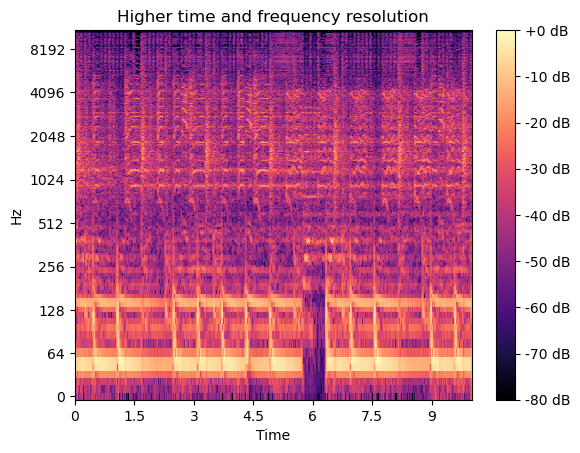

In [11]:
fig, ax = plt.subplots()
D_highres = librosa.stft(sample, hop_length=256, n_fft=2048)
S_db_hr = librosa.amplitude_to_db(np.abs(D_highres), ref=np.max)
img = librosa.display.specshow(S_db_hr, hop_length=256, x_axis='time', y_axis='log',
                               ax=ax)
ax.set(title='Higher time and frequency resolution')
fig.colorbar(img, ax=ax, format="%+2.f dB")

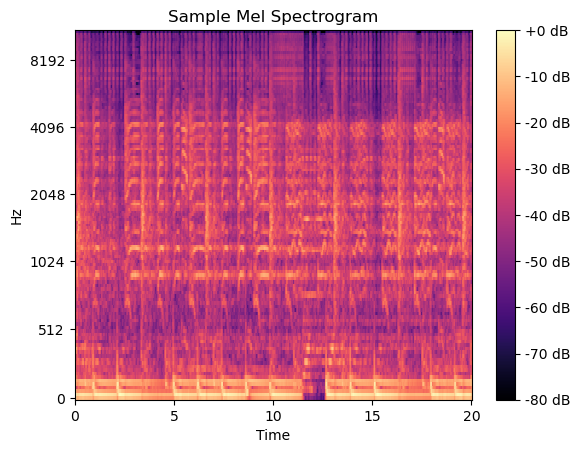

In [12]:
fig, ax = plt.subplots()
M = librosa.feature.melspectrogram(y=sample, sr=sr, n_fft=2048, n_mels=128, hop_length=256) #default number of mel frequency bands
M_db = librosa.power_to_db(M, ref=np.max)
img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=ax)
ax.set(title='Sample Mel Spectrogram')
fig.colorbar(img, ax=ax, format="%+2.f dB")

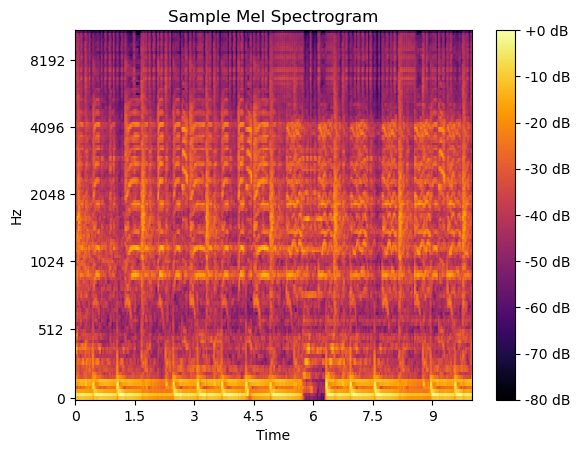

In [13]:
fig, ax = plt.subplots()
M = librosa.feature.melspectrogram(y=sample, sr=sr, n_mels=128) #increased n_mels from default 128, default n_fft is 2048
M_db = librosa.power_to_db(M, ref=np.max)
img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', cmap='inferno', ax=ax)
ax.set(title='Sample Mel Spectrogram')
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [14]:
fig, ax = plt.subplots()

M = librosa.feature.melspectrogram(y=sample, sr=sr, n_mels=128)
M_db = librosa.power_to_db(M, ref=np.max)
img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', cmap='inferno', ax=ax)

ax.axis('off')  # Remove axes

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Save the figure as an image in the "spectrograms" folder
fig.savefig('spectrograms/sample_spectrogram.png', bbox_inches='tight', pad_inches=0)

# Close the figure
plt.close(fig)

In [15]:
image = Image.open('spectrograms/sample_spectrogram.png')

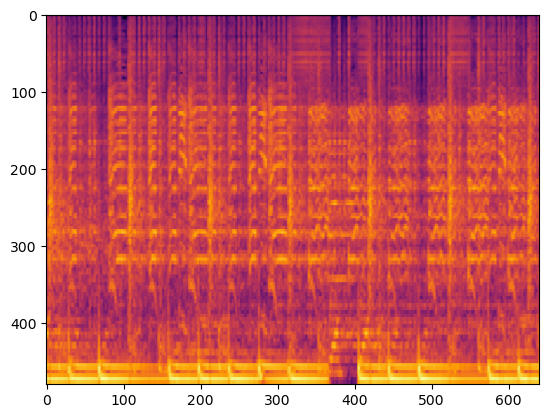

In [16]:
plt.imshow(image)

In [17]:
np.array(image).shape

(480, 640, 4)

def create_spectrograms(audio_folder, spectrogram_folder, n_mels=128):
    if not os.path.exists(spectrogram_folder):
        os.makedirs(spectrogram_folder)

    # List all audio files in the audio folder
    audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]

    for audio_file in audio_files:
        # Load the audio file
        audio_path = os.path.join(audio_folder, audio_file)
        y, sr = librosa.load(audio_path, sr=22050)

        # Compute the mel spectrogram
        M = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=sr/2, n_fft=2048)
        M_db = librosa.power_to_db(M, ref=np.max)
        img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', cmap='inferno', ax=ax)

        # Create a figure and display the spectrogram (optional)
        plt.figure(figsize=(3, 3))
        librosa.display.specshow(M_db, x_axis='time', y_axis='mel', cmap='inferno')
        plt.axis('off')  # Remove axes

        # Save the spectrogram with the same file name
        spectrogram_file = os.path.splitext(audio_file)[0] + '_spectrogram.png'
        spectrogram_path = os.path.join(spectrogram_folder, spectrogram_file)
        plt.savefig(spectrogram_path, bbox_inches='tight', pad_inches=0)
        plt.close()  # Close the figure




def create_spectrograms(audio_folder, spectrogram_folder, n_mels=128):
    if not os.path.exists(spectrogram_folder):
        os.makedirs(spectrogram_folder)

    # List all audio files in the audio folder
    audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]

    # Initialize counters for white squares and duplicates
    white_square_count = 0
    duplicate_count = 0

    for audio_file in audio_files:
        # Construct the spectrogram file path
        spectrogram_file = os.path.splitext(audio_file)[0] + '_spectrogram.png'
        spectrogram_path = os.path.join(spectrogram_folder, spectrogram_file)

        # Check if the spectrogram file already exists, and skip if it does (count duplicates)
        if os.path.exists(spectrogram_path):
            duplicate_count += 1
            continue

        # Load the audio file
        audio_path = os.path.join(audio_folder, audio_file)
        y, sr = librosa.load(audio_path, sr=22050)

        # Compute the mel spectrogram
        M = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=sr/2, n_fft=2048)
        M_db = librosa.power_to_db(M, ref=np.max)

        # Create a figure and display the spectrogram (optional)
        plt.figure(figsize=(3, 3))
        librosa.display.specshow(M_db, x_axis='time', y_axis='mel', cmap='inferno')
        plt.axis('off')  # Remove axes

        # Save the spectrogram
        plt.savefig(spectrogram_path, bbox_inches='tight', pad_inches=0)
        plt.close()  # Close the figure

    print(f"Processed {len(audio_files)} audio files.")
    print(f"Skipped {duplicate_count} duplicate spectrograms.")

In [18]:
def create_spectrograms(audio_folder, spectrogram_folder, n_mels=128, batch_size=100):
    if not os.path.exists(spectrogram_folder):
        os.makedirs(spectrogram_folder)

    # List all audio files in the audio folder
    audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]

    # Initialize counters for white squares and duplicates
    white_square_count = 0
    duplicate_count = 0

    # Process audio files in batches
    for i in range(0, len(audio_files), batch_size):
        batch_audio_files = audio_files[i:i + batch_size]

        for audio_file in batch_audio_files:
            # Construct the spectrogram file path
            spectrogram_file = os.path.splitext(audio_file)[0] + '_spectrogram.png'
            spectrogram_path = os.path.join(spectrogram_folder, spectrogram_file)

            # Check if the spectrogram file already exists, and skip if it does (count duplicates)
            if os.path.exists(spectrogram_path):
                duplicate_count += 1
                continue

            # Load the audio file
            audio_path = os.path.join(audio_folder, audio_file)
            y, sr = librosa.load(audio_path, sr=22050)

            # Compute the mel spectrogram
            M = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=sr/2, n_fft=2048)
            M_db = librosa.power_to_db(M, ref=np.max)

            # Create a figure and display the spectrogram (optional)
            plt.figure(figsize=(3, 3))
            librosa.display.specshow(M_db, x_axis='time', y_axis='mel', cmap='inferno')
            plt.axis('off')  # Remove axes

            # Save the spectrogram
            plt.savefig(spectrogram_path, bbox_inches='tight', pad_inches=0)
            plt.close()  # Close the figure

    print(f"Processed {len(audio_files)} audio files.")
    print(f"Skipped {duplicate_count} duplicate spectrograms.")

In [19]:
# spectrograms with 128 mels
audio_folder = 'audio'  # Path to the audio files
spectrogram_folder = 'specs_sounds_128'  # Path to save the spectrograms
create_spectrograms(audio_folder, spectrogram_folder, n_mels=128)

/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=172
  warnings.warn(
/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=118
  warnings.warn(


Processed 4094 audio files.
Skipped 1817 duplicate spectrograms.
